<a href="https://colab.research.google.com/github/arikwaldinger/portfolio/blob/master/U_Net_Semantic_Segmentation_of_Burn_Scars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Semantic Segmentation of Burn Scars
 **Author: Arik Waldinger**


*Acknowledgment Note: This project contains code developed with the assistance of AI tools (Gemini) and incorporates concepts and code structures adapted from materials provided by Professor John Sullivan.*

# Project Ovewrview:


##   Summary
* This notebook implements a U-Net convolutional neural network for semantic segmentation of burn scars from satellite imagery. The goal is to precisely delineate burned areas, which is a critical task in environmental monitoring and disaster assessment. We leverage the *ChaBuD dataset*, a collection of Sentinel-2 multispectral images, featuring pre- and post-fire observations along with corresponding burn scar masks. The U-Net architecture, known for its effectiveness in medical image segmentation, is adapted here for remote sensing applications, using a pre-trained *ResNet50* encoder to benefit from transfer learning and enhance feature extraction capabilities. The training process incorporates **data augmentation** (rotation, color jitter) and mixed-precision training for improved generalization and efficiency.




## Research Question:

What is the optimal combination of backbone encoder and data augmentation strategy for a U-Net model to accurately segment burn scars from Sentinel-2 multispectral imagery?

### U-Net Backbone Encoder Comparison

| Backbone | Description | Test Reasoning | Parameters |
| :------- | :---------- | :------------- | :--------- |
| **ResNet-18** | Lightweight CNN, shallow residual network | Fast and stable, strong baseline, low compute cost, simple encoder | ≈ 11.7 million |
| **EfficientNet-B0** | Very compact model, optimized via neural architecture search | Tests efficiency-focused design, great for low-memory setups| ≈ 11.7 million |
| **ResNet-50** | Deeper, more expressive CNN, much larger than ResNet-18 | Tests higher-capacity model,  good for challenging patterns | ≈ 25.6 million |
| **SE-ResNeXt50-32x4d** | ResNeXt backbone (grouped convolutions) + Squeeze-and-Excitation attention blocks, multi-path feature processing | Tests modern attention-enhanced CNNs, preforms better on complex textures| ≈ 27 million |

## Burn Scar Machine Learning Motivation

**Wildland Fire (Unplanned/Natural):** Mapping these scars is primarily for damage assessment, disaster response, and risk mitigation. It informs emergency services, helps estimate economic losses, guides post-fire recovery, and highlights areas where immediate action is needed to prevent secondary hazards like mudslides or invasive species outbreaks. Machine learning is invaluable here for rapid, real-time assessment over large, often remote, and hazardous areas.

**Prescribed Fire (Planned/Controlled):** Mapping burn scars from prescribed burns is focused on monitoring effectiveness, ecological restoration outcomes, and adaptive management. It helps land managers verify if the burn achieved its objectives (e.g., fuel reduction, habitat improvement, pest control), assess burn severity and its impact on vegetation and soil, and refine future burn plans. ML can assist in precisely evaluating burn metrics (e.g., burn completeness, severity) to ensure the desired ecological benefits are realized and unintended consequences are minimized.



# Install Packages

Installing packages means adding external libraries or modules to your Python environment, which provide pre-written code for specific functionalities. For instance, `torchgeo` is a specialized library that extends PyTorch to handle geospatial data, offering tools and datasets crucial for remote sensing tasks like working with the *ChaBuD dataset* for burn scar segmentation.

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Install missing packages
!pip install torchviz torchmetrics torchinfo torchgeo

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F # Consolidated nnf and F to just F
from torch.utils.data import DataLoader
from torchvision import transforms

# PyTorch Add-ons
from torchviz import make_dot # For model visualization (optional)
import torch.optim as optim # Consolidated redundant optim import
import torchmetrics # For evaluation metrics
from torchinfo import summary # For model summarization
from tqdm.auto import tqdm # For progress bars
from torchgeo.datasets import ChaBuD # For the dataset
import segmentation_models_pytorch as smp # If using models from this library

# Data Management
import numpy as np
import pandas as pd
import rasterio as rio
from pathlib import Path # For path manipulation
import tempfile # For temporary files

# Plotting & Visualization
from matplotlib import pyplot as plt
from rasterio.plot import show
from rasterio.plot import show_hist
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt # Duplicate, will keep one

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.8/241.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Connect to GPU CUDA (Compute Unified Device Architecture)

Connecting to a GPU CUDA (Compute Unified Device Architecture) allows your program to utilize the powerful parallel processing capabilities of a graphics processing unit. This significantly accelerates computations, especially for tasks like deep learning and scientific simulations, which can be orders of magnitude faster than running on a CPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [ ]:
!nvidia-smi

Fri Dec 12 23:17:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             51W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Image Settings

In [ ]:
#Define Burnt
BURNT_P = 0.1

# Choose an image size
#** Do I need to chose an image size (all are 512x512)
IMG_SIZE = 512

# Load Burn Scar Data Splits From Torch Geo

[ChaBuD Dataset](https://torchgeo.readthedocs.io/en/latest/api/datasets.html#chabud/)
Features:


* Sentinel-2 multispectral imagery
* Inlcudes a binary masks of burned areas
* 12 multispectral bands
* 356 pairs of pre and post images with 10 m per pixel resolution (512x512 px)
* The paired images capture the landscape before and after a fire event









Breakdown of the 12 Sentinel-2 bands and their typical uses:

| Band | Band Name            | Resolution (m) | Common Use / Association                     |
| :--- | :------------------- | :------------- | :------------------------------------------- |
| B01  | Coastal Aeros aerosol| 60             | Atmospheric correction, coastal studies      |
| B02  | Blue                 | 10             | Water bodies, urban areas, atmospheric       |
| B03  | Green                | 10             | Vegetation reflectance, urban areas          |
| B04  | Red                  | 10             | Chlorophyll absorption, urban areas          |
| B05  | Vegetation Red Edge 1| 20             | Vegetation health                            |
| B06  | Vegetation Red Edge 2| 20             | Vegetation health                            |
| B07  | Vegetation Red Edge 3| 20             | Vegetation health                            |
| B08  | NIR                  | 10             | Vegetation biomass, water content            |
| B8A  | Narrow NIR           | 20             | Improved vegetation indices                  |
| B09  | Water Vapour         | 60             | Atmospheric correction                       |
| B11  | SWIR 1               | 20             | Soil moisture, burn scars, snow/ice discrimination |
| B12  | SWIR 2               | 20             | Vegetation water content, burn scars, geology |

In [ ]:
#Remove cache and iniate a fresh downlaod
import shutil
import os

# Define the typical torchgeo cache directory path
# This path might vary slightly depending on your environment,
# but ~/.cache/torchgeo is a common default.
cache_dir = os.path.expanduser("~/.cache/torchgeo")

# You might also want to remove a specific dataset folder if you know its name, e.g.,
# chabud_dataset_path = os.path.join(cache_dir, "ChaBuD")

if os.path.exists(cache_dir):
    print(f"Deleting torchgeo cache directory: {cache_dir}")
    shutil.rmtree(cache_dir)
    print("Cache directory deleted successfully.")
else:
    print(f"Torchgeo cache directory not found at {cache_dir}. Nothing to delete.")


Torchgeo cache directory not found at /root/.cache/torchgeo. Nothing to delete.


In [ ]:
#The 804 files have been randomly split into training (2/3) and validation (1/3) directories, each containing the masks, scenes, and index files.
from datasets import load_dataset
import torchgeo
import shutil
import os

# Define the 12 bands to use
selected_bands = ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12')

# Define the expected path for the ChaBuD dataset within the torchgeo cache
chabud_dataset_path = os.path.join(os.path.expanduser("~"), ".cache", "torchgeo", "ChaBuD")

# Remove the ChaBuD dataset directory if it exists, to ensure a fresh download
if os.path.exists(chabud_dataset_path):
    print(f"Deleting corrupted ChaBuD dataset directory: {chabud_dataset_path}")
    shutil.rmtree(chabud_dataset_path)
    print("ChaBuD directory deleted successfully. Attempting fresh download...")
else:
    print(f"ChaBuD dataset directory not found at {chabud_dataset_path}. Proceeding with download.")


# Load datasets without any transforms initially
tg_train = torchgeo.datasets.ChaBuD(split="train", download=True, bands=selected_bands, transforms=None)
tg_val = torchgeo.datasets.ChaBuD(split="val", download=True, bands=selected_bands, transforms=None)
#add test split

#Chabud Source https://ieeexplore.ieee.org/document/10261881

ChaBuD dataset directory not found at /root/.cache/torchgeo/ChaBuD. Proceeding with download.


100%|██████████| 5.88G/5.88G [03:50<00:00, 25.5MB/s]


Example image and mask key of pytrorch tensor from training data smaple 10 from ChaBuD dataset

In [ ]:
tg_train[10]

{'image': tensor([[[[ 519.,  538.,  555.,  ...,  762.,  746.,  723.],
           [ 538.,  545.,  553.,  ...,  747.,  732.,  710.],
           [ 563.,  555.,  551.,  ...,  737.,  723.,  703.],
           ...,
           [ 510.,  509.,  509.,  ...,  752.,  725.,  698.],
           [ 506.,  506.,  507.,  ...,  742.,  729.,  720.],
           [ 499.,  503.,  504.,  ...,  712.,  718.,  731.]],
 
          [[ 699.,  606.,  650.,  ..., 1051.,  946.,  891.],
           [ 598.,  591.,  662.,  ...,  901.,  951.,  862.],
           [ 543.,  645.,  683.,  ...,  773.,  993.,  684.],
           ...,
           [ 551.,  651.,  704.,  ...,  976., 1060.,  768.],
           [ 679.,  661.,  674.,  ...,  941.,  723.,  705.],
           [ 671.,  653.,  699.,  ...,  834.,  762.,  693.]],
 
          [[ 850.,  767.,  802.,  ..., 1263., 1152., 1079.],
           [ 764.,  736.,  815.,  ..., 1127., 1194., 1020.],
           [ 704.,  819.,  875.,  ...,  918., 1202.,  806.],
           ...,
           [ 690.,  86

# Visualize Data

Import TorchGEO Dataset
Then divide into training, validation, and test splits

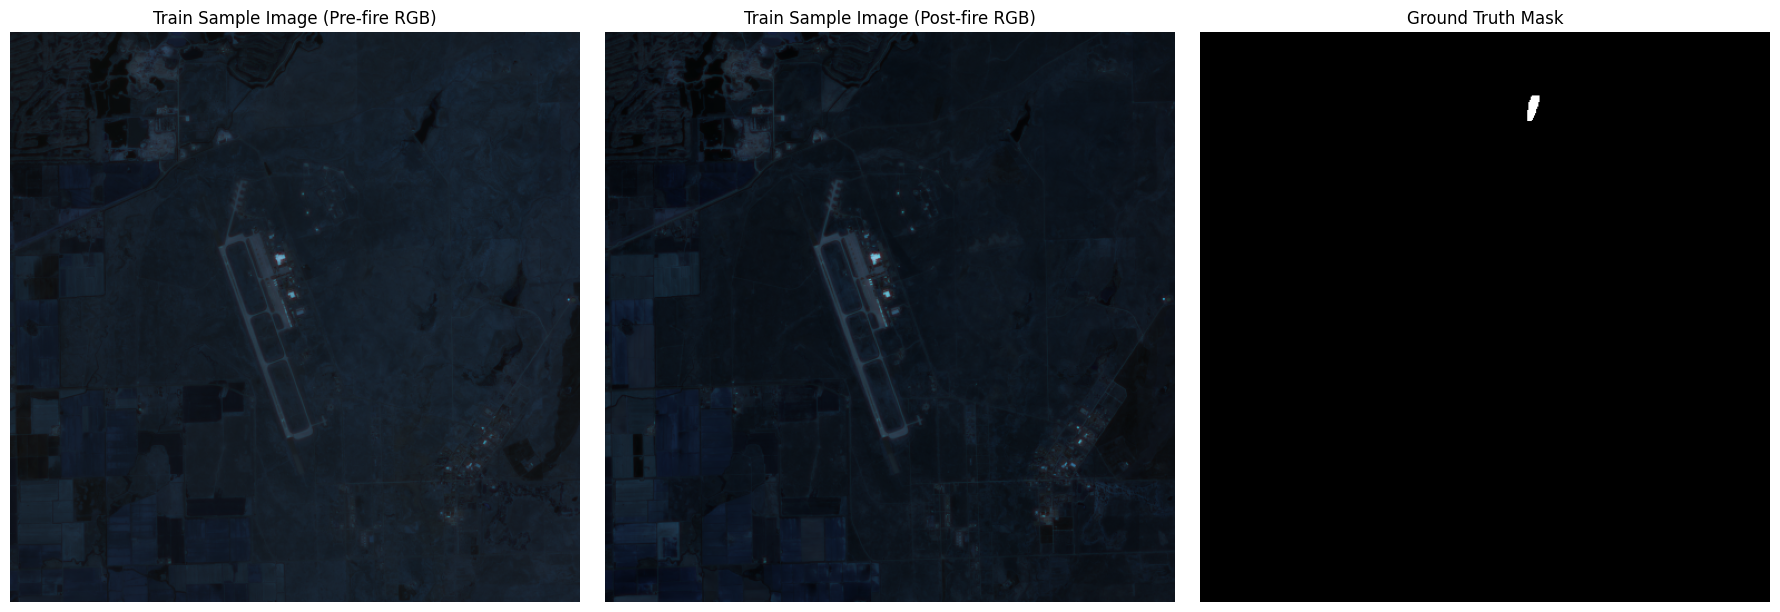

In [ ]:
dx = 90
sample_train = tg_train[dx]

# Extract pre-fire and post-fire images

# Fetch sample WITHOUT the concatenation transform for visualization
temp_tg_train = torchgeo.datasets.ChaBuD(
    split="train", download=False, bands=selected_bands, transforms=None
)
sample_viz = temp_tg_train[dx]

# Process pre-fire image
img_pre_np = sample_viz['image'][0].permute(1, 2, 0).numpy() # (H, W, C) for pre-fire
img_pre_np_normalized = img_pre_np / img_pre_np.max()

# Process post-fire image
img_post_np = sample_viz['image'][1].permute(1, 2, 0).numpy() # (H, W, C) for post-fire
img_post_np_normalized = img_post_np / img_post_np.max()

# Get the ground truth mask
ground_truth_mask = sample_viz['mask'].squeeze().numpy() # Remove channel dim if present

plt.figure(figsize=(18, 6)) # Increased figure size to accommodate 3 plots

# Display pre-fire image (RGB)
plt.subplot(1, 3, 1) # 1 row, 3 columns, first plot
plt.imshow(img_pre_np_normalized[:, :, [0, 1, 2]]) # Displaying the first three bands (R, G, B)
plt.title('Train Sample Image (Pre-fire RGB)')
plt.axis('off')

# Display post-fire image (RGB)
plt.subplot(1, 3, 2) # 1 row, 3 columns, second plot
plt.imshow(img_post_np_normalized[:, :, [0, 1, 2]]) # Displaying the first three bands (R, G, B)
plt.title('Train Sample Image (Post-fire RGB)')
plt.axis('off')

# Display ground truth mask
plt.subplot(1, 3, 3) # 1 row, 3 columns, third plot
plt.imshow(ground_truth_mask, cmap='gray') # Displaying the mask
plt.title('Ground Truth Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

Example Visualization of a Tile of Index Image: 90
(*Pre-burn, Post-Burn, Mask of Burned Area in white*)

Number of Training and Validation Data

In [ ]:
# Get number of samples in train, validation and test
print(f"Number of samples in training dataset: {len(tg_train)}")
print(f"Number of samples in validation dataset: {len(tg_val)}")

Number of samples in training dataset: 278
Number of samples in validation dataset: 78


Get Image and mask Dimensions


> Input image dimensions: torch.Size([2, 12, 512, 512])




*   2 Paired Images
*   12 Channels for each
* 512 pixel width
* 512 Pixel Height



In [ ]:
# Get the IMAGE and MASK dimensions

# Use sample_train (already fetched from tg_train) for image dimensions
sample_train = tg_train[dx]
print(f"Input image dimensions: {sample_train['image'].shape}")

# Fetch a sample from tg_val to get mask dimensions
sample_val = tg_val[0]
print(f"Mask dimensions: {sample_val['mask'].shape}")

Input image dimensions: torch.Size([2, 12, 512, 512])
Mask dimensions: torch.Size([1, 512, 512])


# Normalize Data

Normalize data to improve training stability and speed. Normalizing the dataset can organize data by putting it on the same scale which can make generalization and reaching convergnce easier.

In [ ]:
def computeBandStats(dataset, n_chnls):
    sum_mean = torch.zeros(n_chnls)
    sum_sq_diff = torch.zeros(n_chnls)
    count = 0

    for i in range(len(dataset)):
        img = dataset[i]["image"]
        # Ensure image has a channel dimension before calculating mean over spatial dims
        # If img is (C, H, W), mean over (H, W) is desired
        # If img is (H, W), it's a single channel, mean over (H, W) is still fine
        if img.ndim == 3: # (C, H, W)
            current_mean = torch.nanmean(img.float(), dim=(1, 2))
        elif img.ndim == 2: # (H, W) - single channel image
            current_mean = torch.nanmean(img.float())
        else:
            raise ValueError(f"Unexpected image dimensions: {img.ndim}")

        sum_mean += current_mean
        count += 1

    mean = sum_mean / count if count > 0 else torch.zeros(n_chnls)

    for i in range(len(dataset)):
        img = dataset[i]["image"]
        if img.ndim == 3:
            # Expand mean for broadcasting: (C) -> (C, 1, 1)
            sum_sq_diff += torch.nanmean((img.float() - mean.unsqueeze(1).unsqueeze(2))**2, dim=(1, 2))
        elif img.ndim == 2:
            # For single channel, mean is scalar, no need for unsqueeze
            sum_sq_diff += torch.nanmean((img.float() - mean[0])**2) # Assuming mean[0] for single channel

    std_dev = torch.sqrt(sum_sq_diff / count) if count > 0 else torch.zeros(n_chnls)

    return mean, std_dev

Calculate Mean and Standard Deviation of Wavelength Values

In [ ]:
# Define an initial transform to slice the image channels BEFORE mean/std calculation
def initial_slicing_transform(sample):
    if isinstance(sample, dict) and 'image' in sample:
        # ChaBuD images are (T, C, H, W), where T=2 (pre-fire, post-fire)
        # Concatenate pre-fire and post-fire images along the channel dimension
        if sample['image'].ndim == 4 and sample['image'].shape[0] == 2:
            sample['image'] = torch.cat((sample['image'][0, :, :, :], sample['image'][1, :, :, :]), dim=0) # Concatenate pre and post: (2*C, H, W)
    return sample

# Create a temporary dataset instance to calculate mean and std on sliced data
temp_tg_train_for_stats = torchgeo.datasets.ChaBuD(
    split="train", download=False, bands=selected_bands, transforms=initial_slicing_transform
)

# Now compute mean and std, which will operate on already sliced 12-channel images
tg_mean, tg_std = computeBandStats(temp_tg_train_for_stats, n_chnls=len(selected_bands) * 2) # Doubled channels
print(f"Mean: {tg_mean}")
print(f"St Dev: {tg_std}")

Mean: tensor([ 513.1400,  661.0516,  897.4418, 1078.8259, 1377.5819, 1885.6023,
        2097.9080, 2230.0090, 2295.5020, 2320.7434, 2287.5159, 1639.2689,
         593.4386,  739.4833,  969.7420, 1173.9309, 1462.4218, 1901.7195,
        2106.6221, 2233.5488, 2312.0771, 2351.7852, 2521.4739, 1881.5469])
St Dev: tensor([ 685.2336,  753.9240,  771.9125,  864.7130,  864.3741,  880.0858,
         925.6799,  963.7371,  953.7490,  947.5654, 1099.0408,  909.4517,
         659.5711,  686.2442,  704.5231,  810.9738,  815.0439,  797.1233,
         842.4421,  875.1360,  876.4051,  967.2182, 1079.6442,  933.8649])


# Define Transformations



1.   Concatenate pre and post burn bands
2.   Apply normalization defined above
3. Combine all transforms into one pipeline



In [ ]:
import torch
from torchvision import transforms
import random

# Define a transform to concatenate pre and post fire images
def concatenate_pre_post_bands(sample):
    if isinstance(sample, dict) and 'image' in sample:
        img = sample['image']
        # Ensure image is float for consistency before any ops
        img = img.float() # Convert to float early

        if img.ndim == 4 and img.shape[0] == 2:
            sample['image'] = torch.cat((img[0, :, :, :], img[1, :, :, :]), dim=0) # Result (2*C, H, W)
        elif img.ndim == 3 and img.shape[0] == len(selected_bands) * 2:
            # Image is already concatenated, likely from previous processing (e.g., for stats)
            sample['image'] = img # Just keep it as is
        else:
            # This covers unexpected dimensions.
            raise ValueError(f"Unexpected image dimensions for concatenation step: {img.shape}")
    return sample

# This transform will ONLY normalize the image component of the dictionary
class NormalizeDictImage(object):
    def __init__(self, mean, std):
        self.normalize_transform = transforms.Normalize(mean=mean, std=std)

    def __call__(self, sample):
        if isinstance(sample, dict) and 'image' in sample:
            # The image should already be concatenated and float by this point
            sample['image'] = self.normalize_transform(sample['image'])
        return sample

# --- Define all transformation pipelines ---

# Main transform (concatenate + normalize)
transform = transforms.Compose([
    concatenate_pre_post_bands,
    NormalizeDictImage(mean=tg_mean.tolist(), std=tg_std.tolist())
])

print("Transformation classes and pipelines defined successfully without Color Jitter.")

Transformation classes and pipelines defined successfully without Color Jitter.


Apply normalization transformation to data

In [ ]:
# Assign the final normalization transform to the datasets
tg_train.transforms = transform
tg_val.transforms = transform
#tg_test.transforms = transform

# Data Loader

Data Loader (DataLoader)
A DataLoader in PyTorch is a utility that sits between your dataset (tg_train and tg_val, which contains images and masks) and training or evaluation loop. Its primary purpose is to efficiently load data in manageable chunks.

The batch_size parameter (set to 4 in this cell) defines how many individual samples (in this case, image-mask pairs) are grouped together and processed by the model at once.

In [ ]:
import multiprocessing

batch_size = 4 # Reduced batch size to mitigate RAM issues
num_cpus = multiprocessing.cpu_count() # Define num_cpus

train_dl = DataLoader(tg_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(tg_val, batch_size=batch_size, shuffle=False, num_workers=0)

print("Dataloaders for training and validation created successfully.")


Dataloaders for training and validation created successfully.


## U-Net Model Architecture and Hyperparameters

### Model Architecture:
*   **Model Type**: U-Net (from `segmentation_models_pytorch`)
*   **Encoder**: ResNet50
*   **Encoder Depth**: 5
*   **Encoder Weights**: Pre-trained on ImageNet
*   **Input Channels**: 24 (12 bands for pre-fire + 12 bands for post-fire images)
*   **Output Classes**: 2 (for binary segmentation: Not Burned, Burned)
*   **Decoder Channels**: (256, 128, 64, 32, 16)
*   **Decoder Batch Normalization**

### Hyperparameters:
*   **Epochs**: 50
*   **Batch Size**: 4
*   **Optimizer**: Adam
    *   **Learning Rate (lr)**: 0.0002
    *   **Weight Decay**: 0.01
*   **Learning Rate Scheduler**: StepLR
    *   **Step Size**: 10
    *   **Gamma**: 0.1
*   **Loss Function**: DiceLoss (multiclass mode, 2 classes)
*   **Automatic Mixed Precision (AMP)**

### Data Augmentation Strategy (Training):
*   **Concatenation of Pre/Post Fire Bands**
*   **Random Choice Augmentation**: Randomly applies one of the following:
    *   No augmentation
    *   Random Rotation (degrees=(-10, 10))
    *   Color Jitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1) applied only to RGB bands (B02, B03, B04)
    *   Random Rotation + Color Jitter
*   **Normalization**: Applied after augmentation using calculated mean and standard deviation of all 24 channels.

### Data Preparation:
*   **Training Dataset Size**: 278 samples
*   **Validation Dataset Size**: 78 samples

In [ ]:
import segmentation_models_pytorch as smp


unet = smp.Unet(
    encoder_name="resnet18",       # Choose encoder, e.g., "resnet18", "resnet34", "vgg16"
    encoder_weights="imagenet",   # Use pre-trained weights for better generalization
    in_channels=len(selected_bands) * 2,  # Input channels are now doubled (24 for concatenated pre/post)
    classes=2,                      # Output classes (2 for binary segmentation)
    decoder_channels=(256, 128, 64, 32, 16), # Default for resnet18 depth 5 (5 decoder blocks)
    decoder_use_batchnorm=True      # Match custom UNet's BatchNorm usage
)

# Print a summary using torchinfo
summary(unet, input_size=(batch_size, len(selected_bands) * 2, IMG_SIZE, IMG_SIZE)) # Using global batch_size

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [4, 2, 512, 512]          --
├─ResNetEncoder: 1-1                          [4, 24, 512, 512]         --
│    └─Conv2d: 2-1                            [4, 64, 256, 256]         75,264
│    └─BatchNorm2d: 2-2                       [4, 64, 256, 256]         128
│    └─ReLU: 2-3                              [4, 64, 256, 256]         --
│    └─MaxPool2d: 2-4                         [4, 64, 128, 128]         --
│    └─Sequential: 2-5                        [4, 64, 128, 128]         --
│    │    └─BasicBlock: 3-1                   [4, 64, 128, 128]         73,984
│    │    └─BasicBlock: 3-2                   [4, 64, 128, 128]         73,984
│    └─Sequential: 2-6                        [4, 128, 64, 64]          --
│    │    └─BasicBlock: 3-3                   [4, 128, 64, 64]          230,144
│    │    └─BasicBlock: 3-4                   [4, 128, 64, 64]          295,4

# Define Training and Validation Step

In [ ]:
import torch # Import torch here
import torch.optim as optim # Import optim here
from tqdm.auto import tqdm # Import tqdm here
import torchmetrics # Import torchmetrics

# Import AMP components
from torch.amp import autocast, GradScaler # Changed import to torch.amp

# Define Training Step
def train_step(model: torch.nn.Module, #<- this little bell and whistle creates a data type requirement for the input
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               metric_class, # Changed to metric_class
               epoch: int,
               scaler: GradScaler, # Add scaler parameter
               device: torch.device = device):

  train_loss = 0
  model.to(device) # Send model to device
  model.train() # activate train mode

  # Instantiate a fresh metric for this epoch's training
  acc_metric = metric_class(task="multiclass", num_classes=2, average='micro').to(device)

  for batch, data in enumerate(tqdm(dataloader, desc=f"Training Epoch {epoch}")):

    # Send data to GPU
    X, y = data['image'].to(device), data['mask'].to(device)
    y = y.squeeze(1) # Remove the channel dimension from the mask

    # Debug print for input shape
    # print(f"Input X shape to model: {X.shape}") # Uncomment for debugging

    with autocast('cuda'): # Enable mixed precision - changed to autocast('cuda')
      # 1. Forward pass
      y_pred = model(X) # Model prediction

      # 2. Calculate loss
      loss = loss_fn(y_pred, y) #Calculate loss

    train_loss += loss.item() # Use .item() for scalar loss

    # 3. Update accuracy metric
    y_pred_arg = y_pred.argmax(dim=1)
    acc_metric.update(y_pred_arg, y)

    # 4. Optimizer zero grad
    optimizer.zero_grad() # Zero gradients

    # 5. Loss backward (scale the loss)
    scaler.scale(loss).backward() # Backward pass with scaled loss

    # 6. Optimizer step (unscale gradients and update weights)
    scaler.step(optimizer) # Optimizer step

    # 7. Update the scaler for the next iteration
    scaler.update()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(dataloader)
  train_acc = acc_metric.compute() # Compute final accuracy for the epoch
  acc_metric.reset() # Reset metric state for the next epoch
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

  return train_loss, train_acc

# Define Validation Step
def valtest_step(dataloader: torch.utils.data.DataLoader,
                 model: torch.nn.Module,
                 loss_fn: torch.nn.Module,
                 metric_class, # Changed to metric_class
                 epoch: int,
                 device: torch.device = device):

    # Determine if validation or test split
    split = "Validation" if dataloader.dataset.split == "val" else "Test"

    loss = 0
    model.to(device) # COMPLETE: Send model to device
    model.eval() # put model in eval mode

    # Instantiate a fresh metric for this epoch's validation
    acc_metric = metric_class(task="multiclass", num_classes=2, average='micro').to(device)

    # Turn on inference context manager
    with torch.inference_mode():
        for data in tqdm(dataloader, desc=f"{split} Epoch {epoch}"):

            # Send data to GPU
            X, y = data['image'].to(device), data['mask'].to(device)
            y = y.squeeze(1) # Remove the channel dimension from the mask

            with autocast('cuda'): # Enable mixed precision for validation - changed to autocast('cuda')
                # 1. Forward pass (aka model prediction)
                pred = model(X) # COMPLETE: Model prediction

                # 2. Calculate loss
                loss += loss_fn(pred, y).item() # COMPLETE: Calculate loss, use .item()

            # 3. Update accuracy metric
            pred_arg = pred.argmax(dim=1)
            acc_metric.update(pred_arg, y)

        # Adjust metrics and print out what's happening
        loss /= len(dataloader)
        acc = acc_metric.compute() # Compute final accuracy for the epoch
        acc_metric.reset() # Reset metric state for the next epoch
        print(f"{split} loss: {loss:.5f} | {split} accuracy: {acc:.2f}\n")

    return loss, acc

# Define Loss and Accuracy

In [ ]:
import segmentation_models_pytorch.losses as smp_losses

# Loss and Accuracy
# Establish loss function - using DiceLoss for better segmentation performance
loss_fn = smp_losses.DiceLoss(mode='multiclass', classes=2)

# We will pass the JaccardIndex class and instantiate it inside the training/validation steps
JaccardIndexMetric = torchmetrics.JaccardIndex

In [ ]:
# Cell 6df6eaed was removed as the combination of datasets is no longer needed.

# Initalize Training Loop

This cell initializes the U-Net model, sets up the optimizer (`Adam` with `lr=0.0002`, `weight_decay=0.01`), and defines the `StepLR` learning rate scheduler (`step_size=10`, `gamma=0.1`). It then executes the training for **50 epochs**, managing mixed-precision training with `GradScaler` and tracking performance metrics for both training and validation sets.

In [ ]:
import torch
import segmentation_models_pytorch as smp
import time # Import the time module

# Removed redundant selected_bands definition, using the one from '5yuDi8sfYOVZ'

torch.manual_seed(23)
unet_smp = smp.Unet(
    encoder_name="resnet50",  # <--- CHANGE ENCODER HERE (e.g., "efficientnet-b0", "resnet50", "timm-resnest14d")
    encoder_depth=5,         # Set to 5 for resnet18 default depth, consistent with summary
    decoder_channels=(256, 128, 64, 32, 16), # Match the decoder channels of depth 5 resnet18 encoder
    in_channels=len(selected_bands) * 2,           # Set to the number of input channels in your data (doubled)
    classes=2                # Set to the number of classes in your mask
)

# Establish optimizer
# Reduced weight_decay for less aggressive regularization
optimizer_smp = optim.Adam(unet_smp.parameters(), lr=0.0002, weight_decay=0.01)

# Establish learning rate scheduler
scheduler_smp = optim.lr_scheduler.StepLR(optimizer_smp, step_size=10, gamma=0.1) # Add StepLR scheduler

# Initialize GradScaler for Automatic Mixed Precision
scaler = torch.amp.GradScaler(device='cuda') # Updated to silence FutureWarning

# Epochs
epochs = 50 # Use the same number of epochs

results_smp = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "epoch_runtime": [] # New list to store runtime for each epoch
    }

# Start total training timer
total_start_time = time.time()

for epoch in tqdm(range(epochs)): #<- this bell and whistle gives you a progress bar while training
    print(f"Epoch: {epoch}\n---------")
    # Clear CUDA cache at the beginning of each epoch to free up memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    epoch_start_time = time.time() # Start epoch timer

    # Run train step, passing the metric class
    # !!! Using the standard train_dl here !!!
    train_loss_smp, train_acc_smp = train_step(model=unet_smp, dataloader=train_dl, loss_fn=loss_fn, optimizer=optimizer_smp, metric_class=JaccardIndexMetric, epoch=epoch, scaler=scaler, device=device)

    # Run val step, passing the metric class
    val_loss_smp, val_acc_smp = valtest_step(dataloader=val_dl, model=unet_smp, loss_fn=loss_fn, metric_class=JaccardIndexMetric, epoch=epoch, device=device)

    epoch_end_time = time.time() # End epoch timer
    epoch_duration = epoch_end_time - epoch_start_time

    # Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    results_smp["train_loss"].append(train_loss_smp)
    results_smp["train_acc"].append(train_acc_smp.item() if isinstance(train_acc_smp, torch.Tensor) else train_acc_smp)
    results_smp["val_loss"].append(val_loss_smp)
    results_smp["val_acc"].append(val_acc_smp.item() if isinstance(val_acc_smp, torch.Tensor) else val_acc_smp)
    results_smp["epoch_runtime"].append(epoch_duration)

    # Step the scheduler
    scheduler_smp.step()

# End total training timer
total_end_time = time.time()
total_duration = total_end_time - total_start_time

print(f"\nTotal training runtime: {total_duration:.2f} seconds")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------


Training Epoch 0:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.46918 | Train accuracy: 0.78


Validation Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.38225 | Validation accuracy: 0.83

Epoch: 1
---------


Training Epoch 1:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.34913 | Train accuracy: 0.87


Validation Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.35149 | Validation accuracy: 0.83

Epoch: 2
---------


Training Epoch 2:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.32481 | Train accuracy: 0.86


Validation Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.36877 | Validation accuracy: 0.77

Epoch: 3
---------


Training Epoch 3:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.29852 | Train accuracy: 0.88


Validation Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.27056 | Validation accuracy: 0.88

Epoch: 4
---------


Training Epoch 4:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.25315 | Train accuracy: 0.91


Validation Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.31500 | Validation accuracy: 0.83

Epoch: 5
---------


Training Epoch 5:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.26413 | Train accuracy: 0.90


Validation Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.30568 | Validation accuracy: 0.84

Epoch: 6
---------


Training Epoch 6:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.23450 | Train accuracy: 0.91


Validation Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.34183 | Validation accuracy: 0.81

Epoch: 7
---------


Training Epoch 7:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.26184 | Train accuracy: 0.90


Validation Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.45155 | Validation accuracy: 0.77

Epoch: 8
---------


Training Epoch 8:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.23330 | Train accuracy: 0.91


Validation Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.36510 | Validation accuracy: 0.80

Epoch: 9
---------


Training Epoch 9:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.21246 | Train accuracy: 0.92


Validation Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.27858 | Validation accuracy: 0.84

Epoch: 10
---------


Training Epoch 10:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.20037 | Train accuracy: 0.93


Validation Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.30584 | Validation accuracy: 0.83

Epoch: 11
---------


Training Epoch 11:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.17880 | Train accuracy: 0.93


Validation Epoch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.25635 | Validation accuracy: 0.87

Epoch: 12
---------


Training Epoch 12:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.17600 | Train accuracy: 0.94


Validation Epoch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.30101 | Validation accuracy: 0.85

Epoch: 13
---------


Training Epoch 13:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.18514 | Train accuracy: 0.93


Validation Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.24083 | Validation accuracy: 0.88

Epoch: 14
---------


Training Epoch 14:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.19496 | Train accuracy: 0.93


Validation Epoch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.23583 | Validation accuracy: 0.88

Epoch: 15
---------


Training Epoch 15:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.17441 | Train accuracy: 0.94


Validation Epoch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.29572 | Validation accuracy: 0.83

Epoch: 16
---------


Training Epoch 16:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.17124 | Train accuracy: 0.93


Validation Epoch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.24341 | Validation accuracy: 0.87

Epoch: 17
---------


Training Epoch 17:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.19004 | Train accuracy: 0.93


Validation Epoch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21983 | Validation accuracy: 0.89

Epoch: 18
---------


Training Epoch 18:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.18792 | Train accuracy: 0.93


Validation Epoch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.27794 | Validation accuracy: 0.85

Epoch: 19
---------


Training Epoch 19:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.17128 | Train accuracy: 0.94


Validation Epoch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.23161 | Validation accuracy: 0.89

Epoch: 20
---------


Training Epoch 20:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16962 | Train accuracy: 0.94


Validation Epoch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21726 | Validation accuracy: 0.90

Epoch: 21
---------


Training Epoch 21:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.15387 | Train accuracy: 0.94


Validation Epoch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21639 | Validation accuracy: 0.90

Epoch: 22
---------


Training Epoch 22:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.15741 | Train accuracy: 0.94


Validation Epoch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21373 | Validation accuracy: 0.90

Epoch: 23
---------


Training Epoch 23:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16432 | Train accuracy: 0.94


Validation Epoch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.23735 | Validation accuracy: 0.89

Epoch: 24
---------


Training Epoch 24:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16003 | Train accuracy: 0.95


Validation Epoch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.22207 | Validation accuracy: 0.89

Epoch: 25
---------


Training Epoch 25:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.13995 | Train accuracy: 0.95


Validation Epoch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.23607 | Validation accuracy: 0.88

Epoch: 26
---------


Training Epoch 26:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16216 | Train accuracy: 0.94


Validation Epoch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.20603 | Validation accuracy: 0.90

Epoch: 27
---------


Training Epoch 27:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16345 | Train accuracy: 0.94


Validation Epoch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.20444 | Validation accuracy: 0.90

Epoch: 28
---------


Training Epoch 28:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16742 | Train accuracy: 0.94


Validation Epoch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21824 | Validation accuracy: 0.90

Epoch: 29
---------


Training Epoch 29:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.14151 | Train accuracy: 0.95


Validation Epoch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.25524 | Validation accuracy: 0.88

Epoch: 30
---------


Training Epoch 30:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.15611 | Train accuracy: 0.94


Validation Epoch 30:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21018 | Validation accuracy: 0.90

Epoch: 31
---------


Training Epoch 31:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.14871 | Train accuracy: 0.95


Validation Epoch 31:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.24318 | Validation accuracy: 0.89

Epoch: 32
---------


Training Epoch 32:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.15488 | Train accuracy: 0.95


Validation Epoch 32:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21543 | Validation accuracy: 0.90

Epoch: 33
---------


Training Epoch 33:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.14642 | Train accuracy: 0.95


Validation Epoch 33:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21489 | Validation accuracy: 0.89

Epoch: 34
---------


Training Epoch 34:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.14233 | Train accuracy: 0.94


Validation Epoch 34:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.22376 | Validation accuracy: 0.90

Epoch: 35
---------


Training Epoch 35:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16267 | Train accuracy: 0.94


Validation Epoch 35:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.22195 | Validation accuracy: 0.89

Epoch: 36
---------


Training Epoch 36:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.15400 | Train accuracy: 0.95


Validation Epoch 36:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.22339 | Validation accuracy: 0.89

Epoch: 37
---------


Training Epoch 37:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.15925 | Train accuracy: 0.94


Validation Epoch 37:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.22256 | Validation accuracy: 0.89

Epoch: 38
---------


Training Epoch 38:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.15566 | Train accuracy: 0.94


Validation Epoch 38:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.23591 | Validation accuracy: 0.89

Epoch: 39
---------


Training Epoch 39:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.13457 | Train accuracy: 0.95


Validation Epoch 39:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.23808 | Validation accuracy: 0.89

Epoch: 40
---------


Training Epoch 40:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16024 | Train accuracy: 0.94


Validation Epoch 40:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21020 | Validation accuracy: 0.90

Epoch: 41
---------


Training Epoch 41:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.14864 | Train accuracy: 0.95


Validation Epoch 41:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21486 | Validation accuracy: 0.90

Epoch: 42
---------


Training Epoch 42:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.15679 | Train accuracy: 0.94


Validation Epoch 42:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.24173 | Validation accuracy: 0.89

Epoch: 43
---------


Training Epoch 43:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16187 | Train accuracy: 0.94


Validation Epoch 43:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.22997 | Validation accuracy: 0.89

Epoch: 44
---------


Training Epoch 44:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.13146 | Train accuracy: 0.95


Validation Epoch 44:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.22258 | Validation accuracy: 0.89

Epoch: 45
---------


Training Epoch 45:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.15121 | Train accuracy: 0.95


Validation Epoch 45:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21973 | Validation accuracy: 0.90

Epoch: 46
---------


Training Epoch 46:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.14572 | Train accuracy: 0.95


Validation Epoch 46:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21235 | Validation accuracy: 0.90

Epoch: 47
---------


Training Epoch 47:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.14654 | Train accuracy: 0.95


Validation Epoch 47:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21390 | Validation accuracy: 0.90

Epoch: 48
---------


Training Epoch 48:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.14512 | Train accuracy: 0.95


Validation Epoch 48:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.21519 | Validation accuracy: 0.90

Epoch: 49
---------


Training Epoch 49:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.16004 | Train accuracy: 0.95


Validation Epoch 49:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.22312 | Validation accuracy: 0.89


Total training runtime: 1051.77 seconds


# Plot Loss and Accuracy

Epoch epoch_runtime  train_loss  train_acc  val_loss   val_acc
0       1        22.92s    0.469178   0.781573  0.382246  0.828495
1       2        21.31s    0.349135   0.865134  0.351494  0.830767
2       3        21.31s    0.324814   0.864393  0.368775  0.771881
3       4        20.48s    0.298517   0.881532  0.270556  0.880155
4       5        20.11s    0.253152   0.906567  0.315003  0.834405
5       6        21.66s    0.264132   0.898887  0.305678  0.841044
6       7        21.14s    0.234501   0.910222  0.341825  0.813666
7       8        20.75s    0.261843   0.895469  0.451552  0.768486
8       9        20.71s    0.233303   0.909856  0.365098  0.800252
9      10        20.92s    0.212457   0.917307  0.278580  0.841767
10     11        21.13s    0.200367   0.929544  0.305845  0.831652
11     12        21.08s    0.178795   0.934049  0.256348  0.865078
12     13        20.91s    0.176001   0.936073  0.301014  0.854694
13     14        21.26s    0.185135   0.929483  0.240834  0.875418
14     15        21.40s    0.194962   0.927407  0.235828  0.878091
15     16        20.98s    0.174411   0.943077  0.295719  0.828316
16     17        20.62s    0.171238   0.932033  0.243406  0.873675
17     18        20.81s    0.190039   0.932608  0.219834  0.894592
18     19        20.67s    0.187916   0.930451  0.277939  0.851777
19     20        20.63s    0.171277   0.937068  0.231610  0.892348
20     21        20.89s    0.169623   0.936026  0.217256  0.901537
21     22        20.88s    0.153867   0.943266  0.216393  0.897611
22     23        21.11s    0.157408   0.941889  0.213734  0.902625
23     24        20.99s    0.164316   0.941512  0.237348  0.887161
24     25        20.86s    0.160031   0.945012  0.222072  0.893587
25     26        20.71s    0.139950   0.949439  0.236067  0.880737
26     27        21.73s    0.162155   0.940392  0.206030  0.900760
27     28        21.50s    0.163448   0.943751  0.204440  0.902349
28     29        20.58s    0.167422   0.940321  0.218236  0.897715
29     30        20.63s    0.141514   0.947841  0.255242  0.876036
30     31        20.30s    0.156108   0.944110  0.210178  0.900707
31     32        20.01s    0.148712   0.947259  0.243177  0.890151
32     33        21.11s    0.154880   0.945380  0.215435  0.897923
33     34        20.01s    0.146424   0.946449  0.214890  0.893741
34     35        21.14s    0.142333   0.944803  0.223761  0.895315
35     36        21.37s    0.162671   0.943125  0.221948  0.887730
36     37        21.74s    0.154003   0.945498  0.223386  0.888066
37     38        21.58s    0.159251   0.938946  0.222559  0.889819
38     39        20.63s    0.155660   0.940760  0.235911  0.885828
39     40        21.81s    0.134575   0.951146  0.238077  0.891207
40     41        21.36s    0.160235   0.942158  0.210200  0.900608
41     42        22.06s    0.148643   0.946450  0.214863  0.897941
42     43        20.43s    0.156786   0.942077  0.241731  0.888790
43     44        21.76s    0.161866   0.944936  0.229965  0.886480
44     45        21.56s    0.131456   0.951917  0.222585  0.890275
45     46        20.13s    0.151215   0.946626  0.219733  0.899700
46     47        20.09s    0.145715   0.950118  0.212352  0.898059
47     48        21.55s    0.146539   0.945825  0.213900  0.895441
48     49        20.78s    0.145122   0.947420  0.215188  0.896309
49     50        21.32s    0.160041   0.945513  0.223120  0.889547

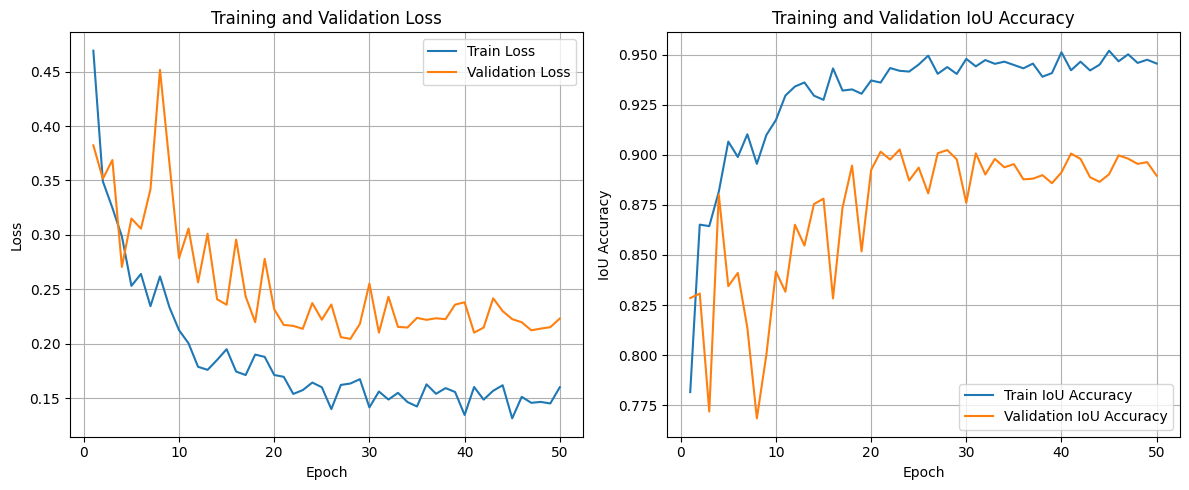

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from the results_smp dictionary
results_df = pd.DataFrame(results_smp)

# Add an 'Epoch' column for better readability
results_df['Epoch'] = range(1, len(results_df) + 1)

# Reorder columns to have Epoch first, then runtime
results_df = results_df[['Epoch', 'epoch_runtime', 'train_loss', 'train_acc', 'val_loss', 'val_acc']]

# Format epoch_runtime to two decimal places
results_df['epoch_runtime'] = results_df['epoch_runtime'].apply(lambda x: f'{x:.2f}s')

# Display the DataFrame
display(results_df)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(results_df['Epoch'], results_df['train_loss'], label='Train Loss')
plt.plot(results_df['Epoch'], results_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(results_df['Epoch'], results_df['train_acc'], label='Train IoU Accuracy')
plt.plot(results_df['Epoch'], results_df['val_acc'], label='Validation IoU Accuracy')
plt.title('Training and Validation IoU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('IoU Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Interpreting Model Performance: Plots and Quantitative Metrics

#### Loss and Accuracy Plots (Training and Validation)

*   **Converging Loss**: Both training and validation loss should decrease. Increasing validation loss while training loss decreases indicates **overfitting**.
*   **Increasing Accuracy**: Both training and validation IoU accuracy should increase. High losses or low accuracies suggest **underfitting**.

#### Quantitative Validation Metrics (Per-Class and Macro Average)

These tables offer a numerical evaluation of the model's performance on the validation set for each class.

*   **IoU (Intersection over Union) / Jaccard Index**: Measures the overlap between the predicted mask and the ground truth mask. A higher IoU (closer to 1) indicates better overlap and more accurate segmentation. It's calculated as (Area of Overlap) / (Area of Union).
*   **Dice Score (F1-score)**: Similar to IoU, the Dice Score also measures similarity. It's often very close in value to IoU and is calculated as (2 * Area of Overlap) / (Sum of Areas). Higher is better.
*   **Precision**: Proportion of correctly predicted positive pixels out of all pixels predicted as positive.
*   **Recall (Sensitivity)**: Proportion of actual positive pixels that were correctly identified by the model.

**Interpreting Per-Class vs. Macro Average:**

*   **Per-Class Metrics**: Show performance for specific classes ('Not Burned', 'Burned'). Important for understanding performance on imbalanced classes.
*   **Macro Average Metrics**: Provide an overall summary by averaging per-class metrics equally, preventing dominant classes from skewing the total.

## Display Validation Predictions of Burned Scars


--- Example Validation Predictions ---
Displaying example 1 (dataset index: 5):


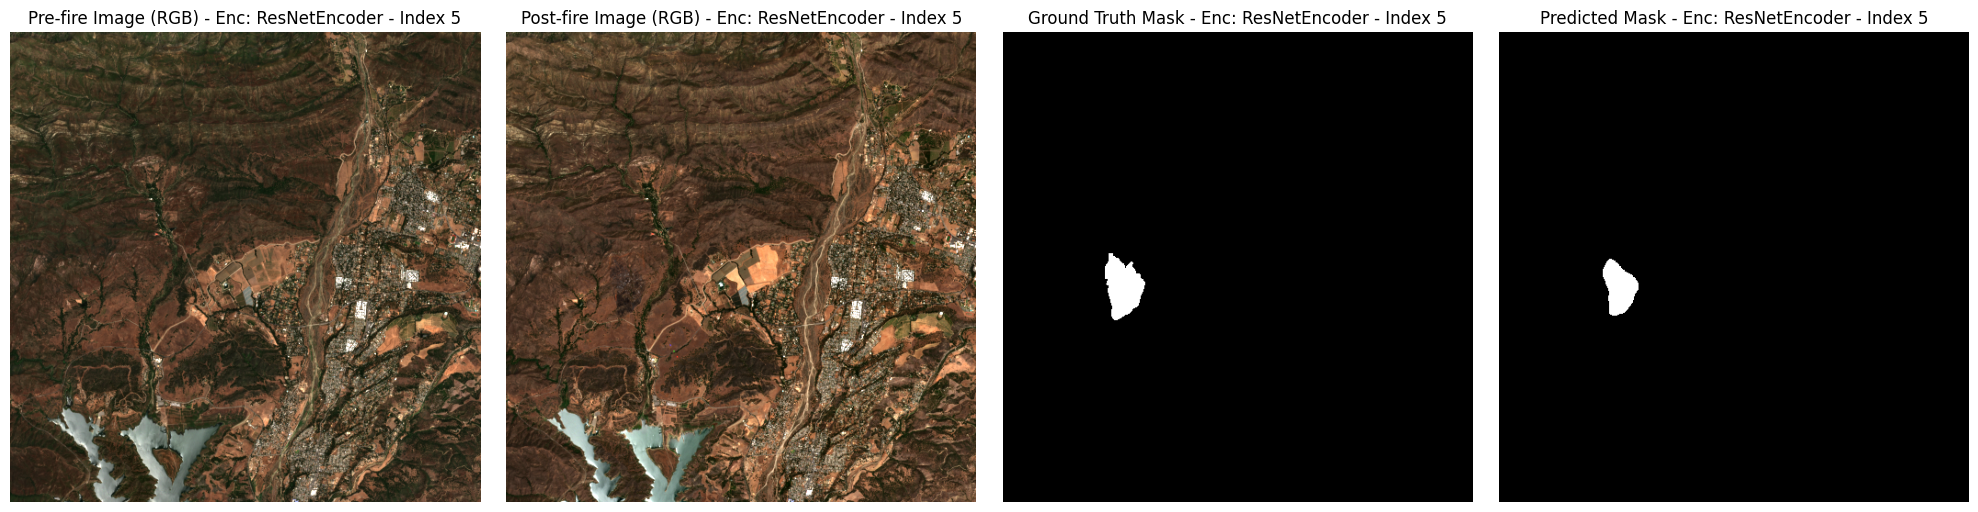

Displaying example 2 (dataset index: 70):


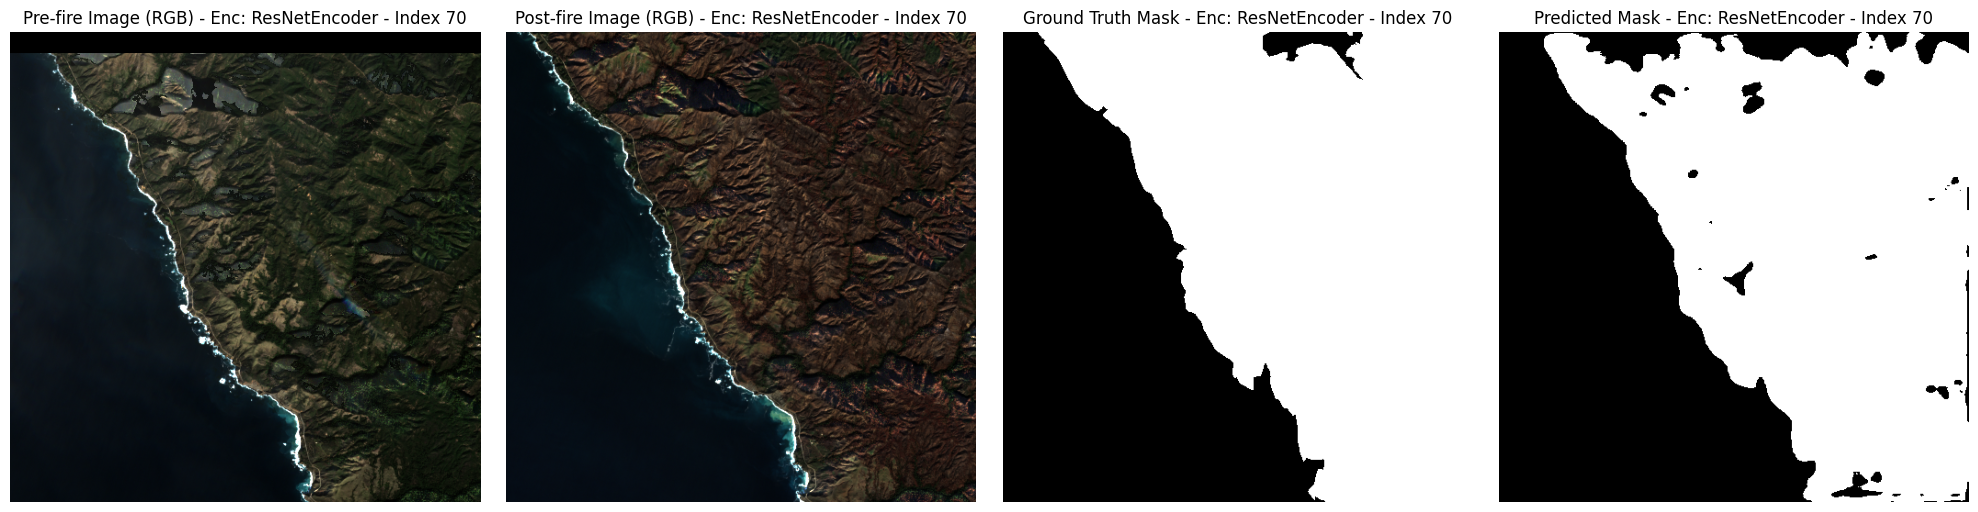

Displaying example 3 (dataset index: 72):


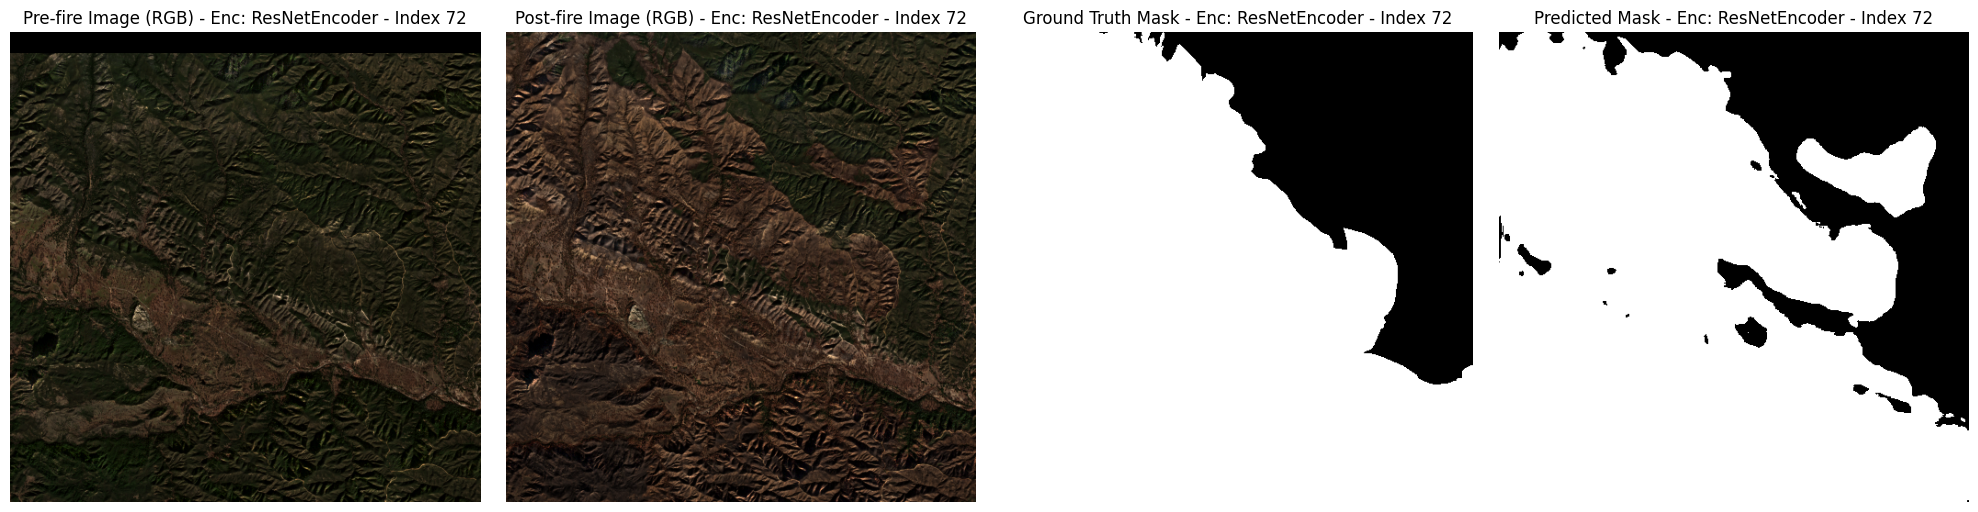

In [ ]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

print("\n--- Example Validation Predictions ---")

# --- USER CONFIGURATION START ---
# To display specific images, provide a list of indices:
indices_to_display = [5, 70, 72] # Always display image indices 5, 70, and 72

# The following lines for random selection are no longer needed for fixed indices:
# selected_large_burn_indices = random.sample(large_burn_area_indices, min(len(large_burn_area_indices), 4))
# indices_to_display = [5] + selected_large_burn_indices
# indices_to_display = sorted(list(set(indices_to_display))) # Remove duplicates and sort for consistency

# If you want random examples, set indices_to_display to None or an empty list,
# and specify the number of random examples you'd like to see:
# num_random_examples = 3 # This is now unused given fixed indices
# --- USER CONFIGURATION END ---

# Set the model to evaluation mode
unet_smp.eval()

# Get the encoder backbone name
encoder_backbone_name = type(unet_smp.encoder).__name__ # Get the class name of the encoder

# Prepare the list of indices to iterate over
display_indices = indices_to_display # Ensure display_indices is updated with the new list

for i, current_idx in enumerate(display_indices): # Loop through the selected indices
    print(f"Displaying example {i+1} (dataset index: {current_idx}):")
    # Select a sample from the validation set
    sample = tg_val[current_idx]

    # Prepare input for model
    image_tensor = sample['image'].unsqueeze(0).to(device) # Add batch dimension, send to device
    ground_truth_mask = sample['mask'].squeeze().cpu().numpy() # Remove channel dim, to CPU, to numpy

    # Model inference
    with torch.no_grad():
        with torch.amp.autocast('cuda'): # Use autocast for inference
            prediction = unet_smp(image_tensor)
    predicted_mask = torch.argmax(prediction, dim=1).squeeze().cpu().numpy()

    # Denormalize and separate images for display
    image_for_display = sample['image'].cpu() # Move image to CPU and remove batch dimension for processing

    # Make sure tg_mean and tg_std are 1D tensors matching image_for_display channels
    # Reshape mean and std for broadcasting (C, 1, 1)
    mean_tensor = tg_mean.view(-1, 1, 1)
    std_tensor = tg_std.view(-1, 1, 1)

    # Perform denormalization
    image_denormalized = (image_for_display * std_tensor) + mean_tensor

    # Scale image values to a displayable range before clamping
    # Sentinel-2 reflectance values are typically in a range like 0-10000 or higher.
    # For visualization, we need to scale them to 0-1. Dividing by a max value like 3000
    # is a common heuristic for natural color composites.
    image_denormalized = image_denormalized / 3000.0 # Adjust scaling factor if images are too dark/bright

    # Clip values to [0, 1] for proper visualization
    image_denormalized = torch.clamp(image_denormalized, 0, 1)

    # Separate pre-fire and post-fire images
    num_bands = len(selected_bands)
    pre_fire_image = image_denormalized[:num_bands]
    post_fire_image = image_denormalized[num_bands:]

    # Define RGB indices for visualization (B04, B03, B02 are typical R, G, B for Sentinel-2)
    # In `selected_bands = ('B01', 'B02', 'B03', 'B04', ...)`, B04 is index 3, B03 is index 2, B02 is index 1
    rgb_indices = [3, 2, 1] # Corresponding to B04, B03, B02

    # Permute to (H, W, C) for matplotlib and select RGB bands
    pre_fire_rgb = pre_fire_image[rgb_indices, :, :].permute(1, 2, 0).numpy()
    post_fire_rgb = post_fire_image[rgb_indices, :, :].permute(1, 2, 0).numpy()

    # Plotting
    plt.figure(figsize=(20, 5)) # Adjust figure size for 4 plots

    plt.subplot(1, 4, 1)
    plt.imshow(pre_fire_rgb)
    plt.title(f'Pre-fire Image (RGB) - Enc: {encoder_backbone_name} - Index {current_idx}')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(post_fire_rgb)
    plt.title(f'Post-fire Image (RGB) - Enc: {encoder_backbone_name} - Index {current_idx}')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title(f'Ground Truth Mask - Enc: {encoder_backbone_name} - Index {current_idx}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f'Predicted Mask - Enc: {encoder_backbone_name} - Index {current_idx}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Quantitative Performance Metrics on Validation Set


*   **Intersection over Union (IoU) / Jaccard Index**: A common metric for segmentation, measuring the overlap between predicted and ground truth masks.
*   **Dice Score (F1-score)**: Another popular metric, often correlating closely with IoU, that indicates similarity between two samples.
*   **Precision**: The proportion of positive identifications that were actually correct.
*   **Recall (Sensitivity)**: The proportion of actual positives that were identified correctly.

These metrics are calculated per-class .

In [ ]:
import torchmetrics
import pandas as pd
from tqdm.auto import tqdm
from torchmetrics import F1Score # Corrected import to use F1Score for Dice

# Initialize metrics for binary segmentation
# We set average='none' to get per-class metrics
num_classes = 2

iou_metric = torchmetrics.JaccardIndex(task="multiclass", num_classes=num_classes, average='none').to(device)
dice_metric = F1Score(task="multiclass", num_classes=num_classes, average='none').to(device) # Using F1Score for Dice
precision_metric = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='none').to(device)
recall_metric = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='none').to(device)

unet_smp.eval()

# Loop through the validation dataloader to accumulate metrics
with torch.inference_mode():
    for data in tqdm(val_dl, desc="Calculating Validation Metrics"):
        X, y = data['image'].to(device), data['mask'].to(device)
        y = y.squeeze(1)

        with torch.amp.autocast('cuda'):
            pred = unet_smp(X)

        pred_labels = torch.argmax(pred, dim=1)

        iou_metric.update(pred_labels, y)
        dice_metric.update(pred_labels, y)
        precision_metric.update(pred_labels, y)
        recall_metric.update(pred_labels, y)

# Compute final metrics
iou_per_class = iou_metric.compute().cpu().numpy()
dice_per_class = dice_metric.compute().cpu().numpy()
precision_per_class = precision_metric.compute().cpu().numpy()
recall_per_class = recall_metric.compute().cpu().numpy()

# Create a DataFrame for better display
metrics_df = pd.DataFrame({
    'Class': ['Not Burned', 'Burned'],
    'IoU': iou_per_class,
    'Dice Score': dice_per_class,
    'Precision': precision_per_class,
    'Recall': recall_per_class
})

print("\n--- Quantitative Validation Metrics (Per Class) ---")
display(metrics_df)

# Optionally, calculate macro average for overall summary
macro_iou = torchmetrics.JaccardIndex(task="multiclass", num_classes=num_classes, average='macro').to(device)
macro_dice = F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device) # Corrected to use F1Score for Dice
macro_precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='macro').to(device)
macro_recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='macro').to(device)

# Reset and re-compute for macro average (or accumulate within the loop if desired)
# For simplicity, re-run inference if necessary, or just use the already updated metrics
macro_iou.reset(); macro_dice.reset(); macro_precision.reset(); macro_recall.reset()

with torch.inference_mode():
    for data in tqdm(val_dl, desc="Calculating Macro Average Metrics"):
        X, y = data['image'].to(device), data['mask'].to(device)
        y = y.squeeze(1)

        with torch.amp.autocast('cuda'):
            pred = unet_smp(X)

        pred_labels = torch.argmax(pred, dim=1)

        macro_iou.update(pred_labels, y)
        macro_dice.update(pred_labels, y)
        macro_precision.update(pred_labels, y)
        macro_recall.update(pred_labels, y)

macro_metrics_df = pd.DataFrame({
    'Metric': ['IoU', 'Dice Score', 'Precision', 'Recall'],
    'Macro Average': [
        macro_iou.compute().item(),
        macro_dice.compute().item(),
        macro_precision.compute().item(),
        macro_recall.compute().item()
    ]
})

print("\n--- Quantitative Validation Metrics (Macro Average) ---")
display(macro_metrics_df)


Calculating Validation Metrics:   0%|          | 0/20 [00:00<?, ?it/s]


--- Quantitative Validation Metrics (Per Class) ---


Class       IoU  Dice Score  Precision    Recall
0  Not Burned  0.935319    0.966579   0.952251  0.981343
1      Burned  0.622181    0.767092   0.856941  0.694296

Calculating Macro Average Metrics:   0%|          | 0/20 [00:00<?, ?it/s]


--- Quantitative Validation Metrics (Macro Average) ---


Metric  Macro Average
0         IoU       0.778750
1  Dice Score       0.866835
2   Precision       0.904596
3      Recall       0.837820

# Reflection/Discussion




Generally the 'Burned' class likely appears easier to classify because burn scars have a highly distinct and consistent spectral signature in multispectral imagery, especially when comparing pre- and post-fire conditions. 'Not Burned' class encompasses a much wider and more varied range of land covers, making it inherently more challenging for the model to define and segment precisely.


The Resnet 50 encoder performed the highest overall performance. The Resnet 50 boasted a 0.889 validation accuracy (indicating best generalization), 0.223 validation loss, the highest IoU 0.935 (Burned Class) and Dice Score 0.966, indicating the model performed very well at detecting burn scars. ResNet50 likely performed best because its deeper architecture and residual connections allowed it to learn more complex features from the multispectral satellite imagery. Combined with ImageNet pre-trained weights, it could better capture intricate burn scar patterns and generalize effectively to the dataset.



ResNet18 likely underperformed due to its limited capacity for learning complex features inherent in multispectral burn scar imagery, showing only a minimal difference from ResNet50. In contrast, the more complex SE-ResNeXt50-32x4d exhibited clear signs of overfitting, with high training accuracy but significantly lower validation performance, especially for the 'Not Burned' class. This suggests it was either too complex for the available data or not optimally tuned for the task, highlighting the potential for bias when pre-tuning specific backbones.



Despite trying various data augmentation strategies, including simple rotation, color jitter, a combination of both, and a random choice approach, none improved upon the strong performance of the baseline model, which was trained without any augmentation. Doubling the dataset with rotated copies even led to a slight performance decrease, indicating that general-purpose augmentations might introduce redundant information or noise, hindering rather than helping generalization for this specific burn scar segmentation task. This suggests that the baseline model was already robust, and future augmentation efforts should be highly targeted, carefully controlled, and treated as hyperparameters to address specific data weaknesses without creating unrealistic training examples. It is also possible that there was potential over augmenting or augmenting too many training samples which confused the model and hindered it's a ability to generalize.





To further enhance the model's performance, several avenues could be explored. Given the small sample size of training validation images, the most impactful improvement would come from expanding the dataset both in terms of quantity and geographically. Additionally, a thorough re-tuning of hyperparameters could uncover more optimal configurations, and exploring advanced data augmentation techniques like elastic deformations, CutMix, or MixUp might improve generalization. Incorporating spectral indices such as NDVI, NDWI, or NDBr directly into the dataset images could also provide richer contextual information for the model. Lastly, experimenting with alternative model architectures, such as a Siamese U-net (with two separate encoders for pre- and post-burn images), and optimizing the loss function with specialized Dice Loss or hybrid approaches could lead to significant gains.